# Analysis of timeseries data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import sklearn

from pandas import read_csv
from pandas import DataFrame
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

from tqdm.notebook import tnrange 

from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Data import 

Let us import the dataseries of a single variable. 

,x
0,0.000000
1,1.000000
2,-0.485975
3,-0.747044
4,0.864313


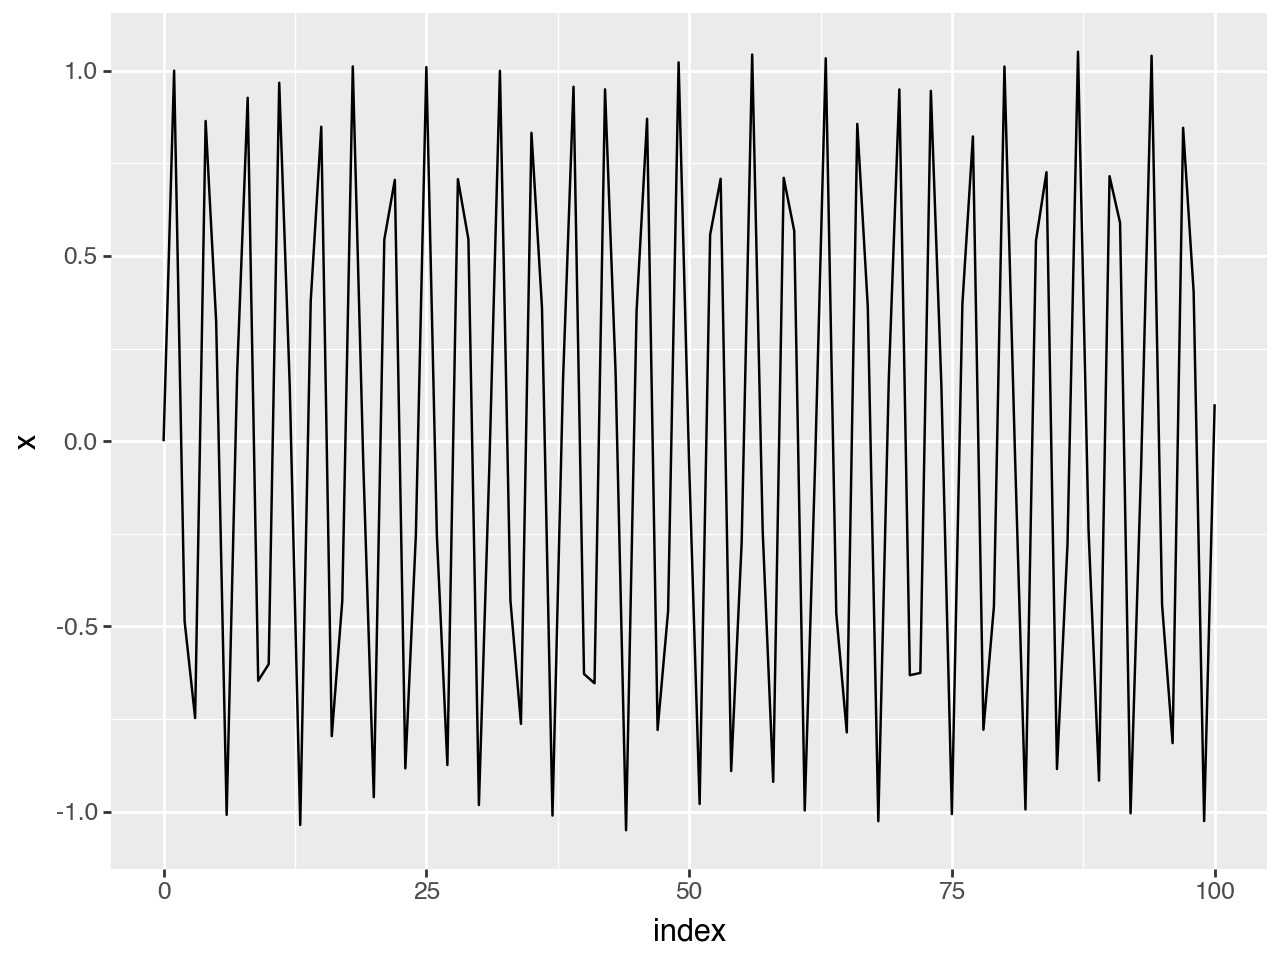

In [2]:
df = read_csv('data/timeseries/challenge.csv', index_col=0)
display(head(df))
ggplot(df.loc[:100,].reset_index()) + geom_line(aes(x='index',y='x'))

## II. Preparation for model fitting

Let us consider a mode where $x_{i+1}$ depends on three previous values. Then we need to collect the data in the right format.

In [3]:
df = (df
      .assign(s0 = df['x'].shift(1))
      .assign(s1 = df['x'].shift(2))
      .assign(s2 = df['x'].shift(3)))

mdisplay([head(df), head(df.loc[3:])], ['Timeseries with delayed values', 'Same without missing values'])

Timeseries with delayed values Same without missing values 
 
 
 x 
 s0 
 s1 
 s2 
 
 
 
 
 0.000000 
 NaN 
 NaN 
 NaN 
 
 
 1.000000 
 0.000000 
 NaN 
 NaN 
 
 
 -0.485975 
 1.000000 
 0.000000 
 NaN 
 
 
 -0.747044 
 -0.485975 
 1.000000 
 0.0 
 
 
 0.864313 
 -0.747044 
 -0.485975 
 1.0 
 
 
 
 
 
 x 
 s0 
 s1 
 s2 
 
 
 
 
 -0.747044 
 -0.485975 
 1.000000 
 0.000000 
 
 
 0.864313 
 -0.747044 
 -0.485975 
 1.000000 
 
 
 0.323895 
 0.864313 
 -0.747044 
 -0.485975 
 
 
 -1.008396 
 0.323895 
 0.864313 
 -0.747044 
 
 
 0.185753 
 -1.008396 
 0.323895 
 0.864313

## III. Model fitting

To find a model we can build a linear model $x\sim s0+s1+s2+1$.

In [4]:
from matplotlib.pyplot import bar as bar_plot

R^2 score: 0.9998102071811406
sigma=0.010075565023370914


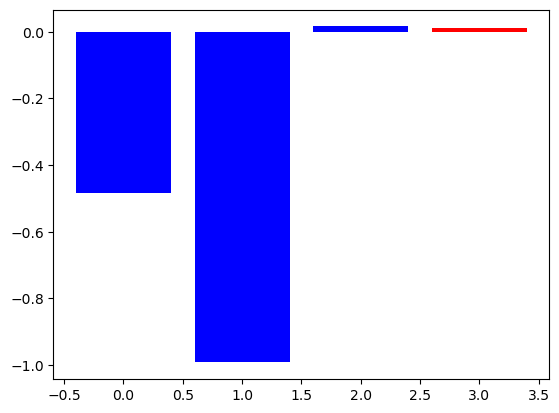

In [5]:
X = df.loc[ 3:, ['s0', 's1', 's2']]
y = df.loc[ 3:, 'x']

# Model fitting
model = LinearRegression()
model.fit(X, y)
print('R^2 score: {}'.format(model.score(X, y)))

# Finding the variance parameter
residuals = model.predict(X) - y
sigma = np.std(residuals)
print('sigma={}'.format(sigma))

# Standard visualisation of coefficients
w = np.append(model.coef_, model.intercept_)
bar_plot(range(4), w, color = ['blue'] * 3 + ['red'])
plt.show()

## IV. Diagostics

Model is well-fitted if residuals do not correlate with previous values and are approximately normally distributed.

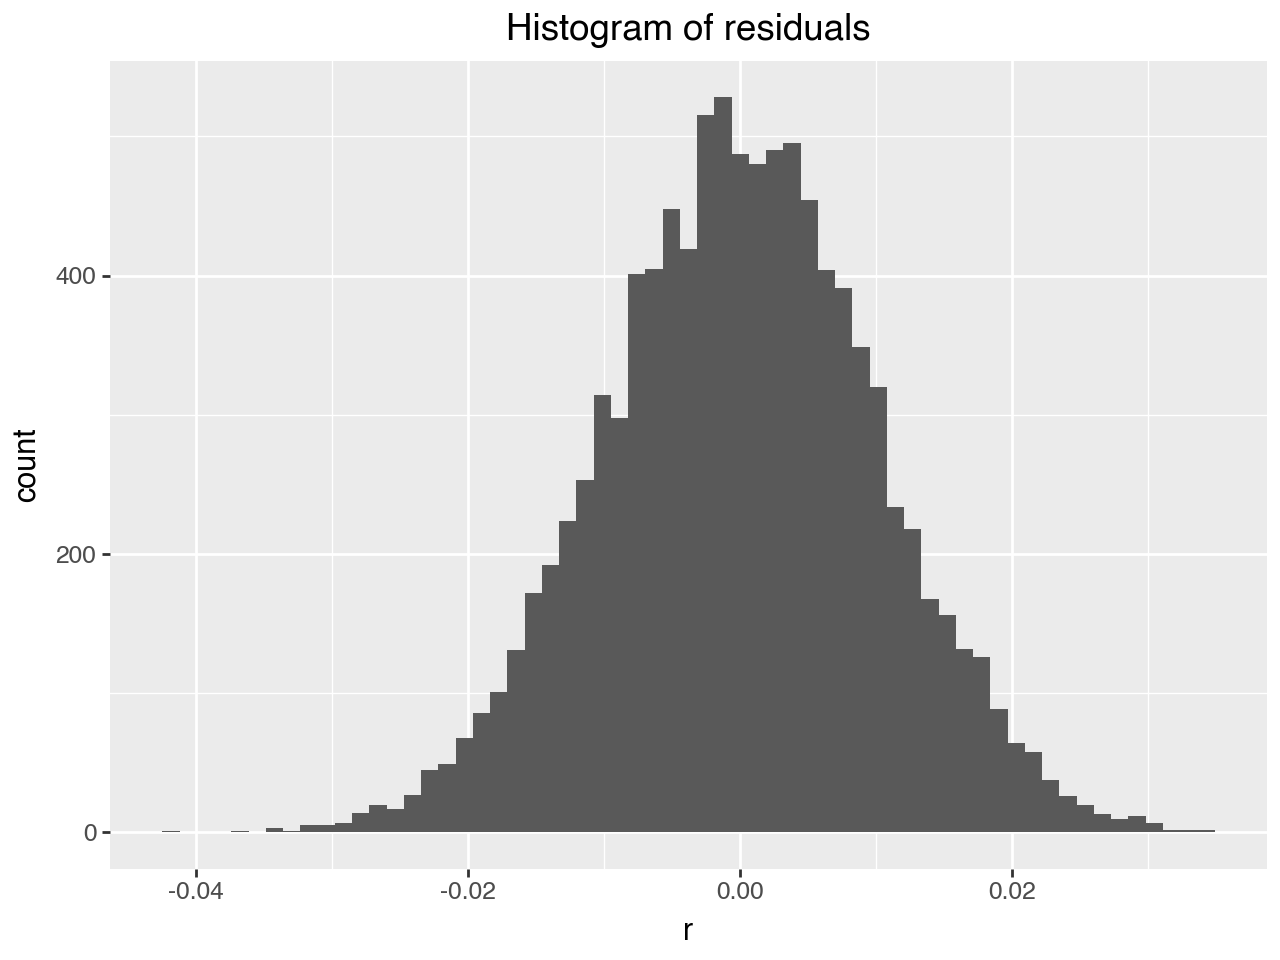

In [6]:
# Histogram
p = ggplot(DataFrame({'r': residuals})) + geom_histogram(aes(x = 'r'), bins=61)
display(p +  ggtitle('Histogram of residuals'))

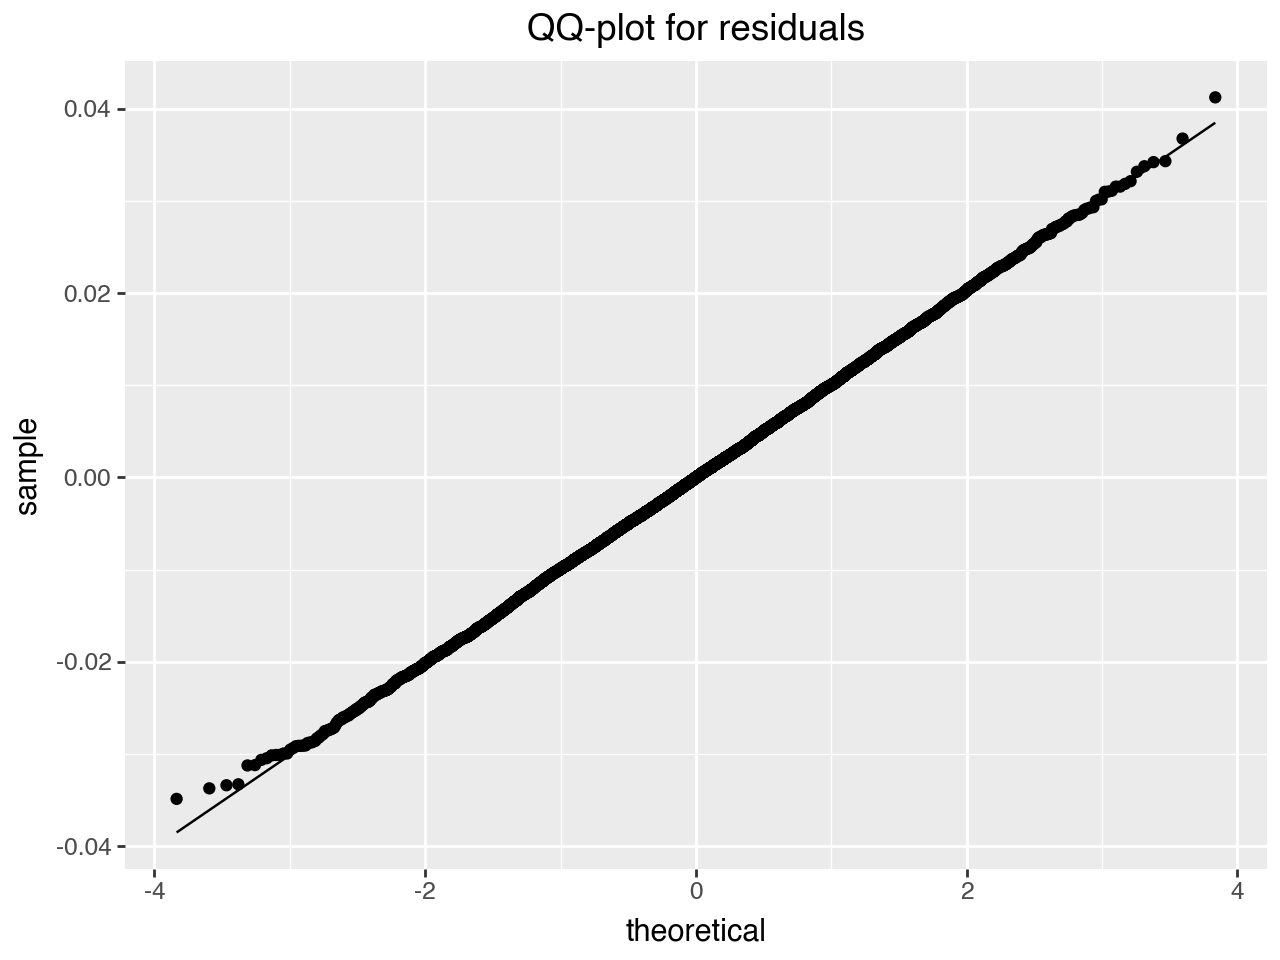

In [7]:
# Distribution test
residuals = y - model.predict(X)
p = ggplot(DataFrame({'r': residuals}), aes(sample = 'r'))
display(p + stat_qq() + stat_qq_line() + ggtitle('QQ-plot for residuals'))

In [8]:
from scipy.stats import pearsonr

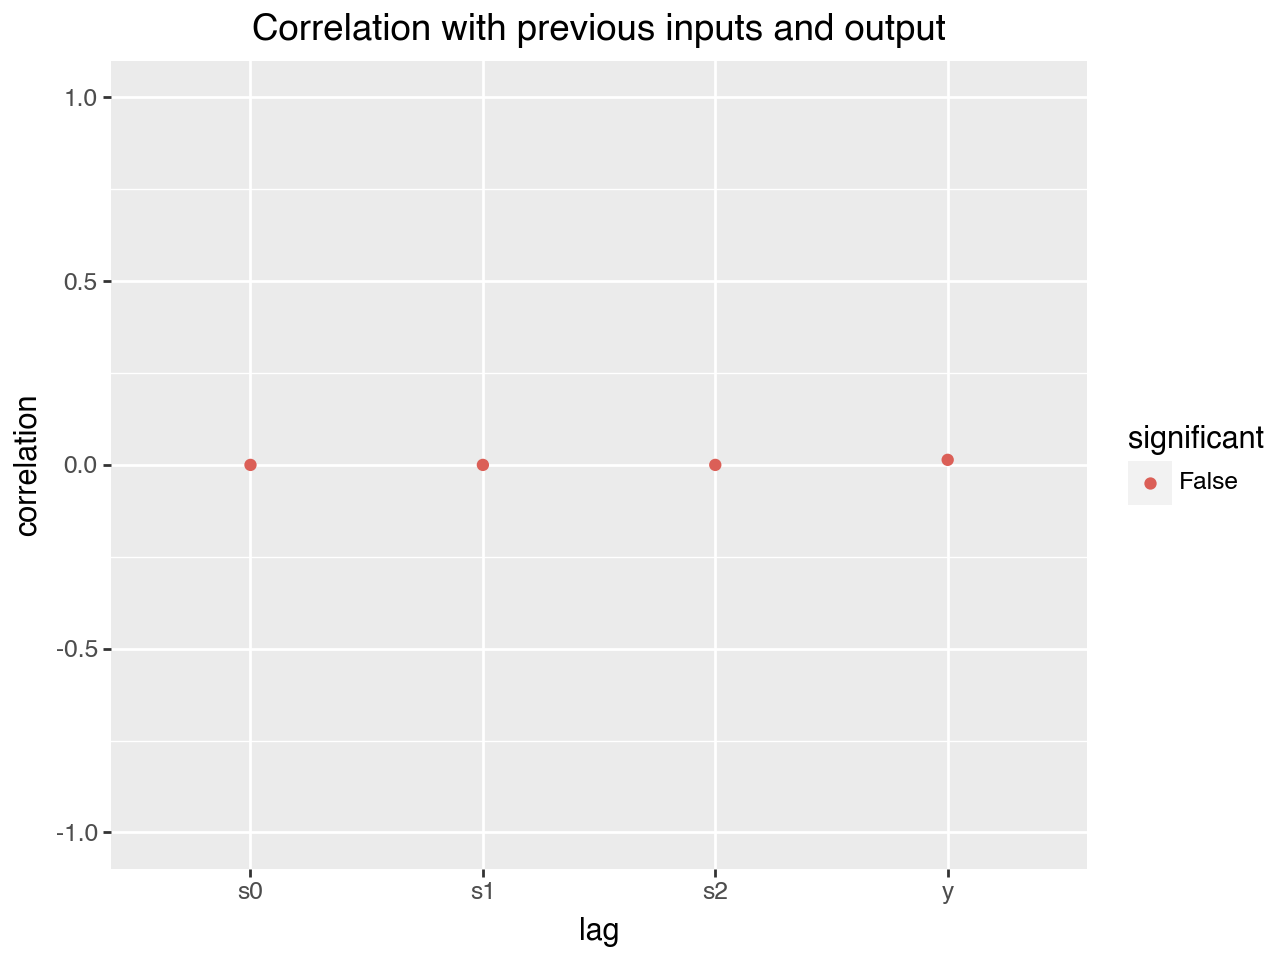

In [9]:
# Let use pearsonr function as it gives a pvalue for non-correlation hypothesis 
pvalue = [None] * 4
cor_coef = [None] * 4
cor_coef[0], pvalue[0] = pearsonr(residuals, X['s0'])
cor_coef[1], pvalue[1] = pearsonr(residuals, X['s1'])
cor_coef[2], pvalue[2] = pearsonr(residuals, X['s2'])
cor_coef[3], pvalue[3] = pearsonr(residuals, y)


sdf = DataFrame({'lag': ['s0', 's1', 's2', 'y'], 'correlation': cor_coef, 'pvalue': pvalue}).assign(significant=lambda df: df['pvalue'] < 0.05)
p = ggplot(sdf) + geom_point(aes(x='lag', y='correlation', colour='significant'))
p = p + ylim(-1,1) + ggtitle('Correlation with previous inputs and output')
display(p)

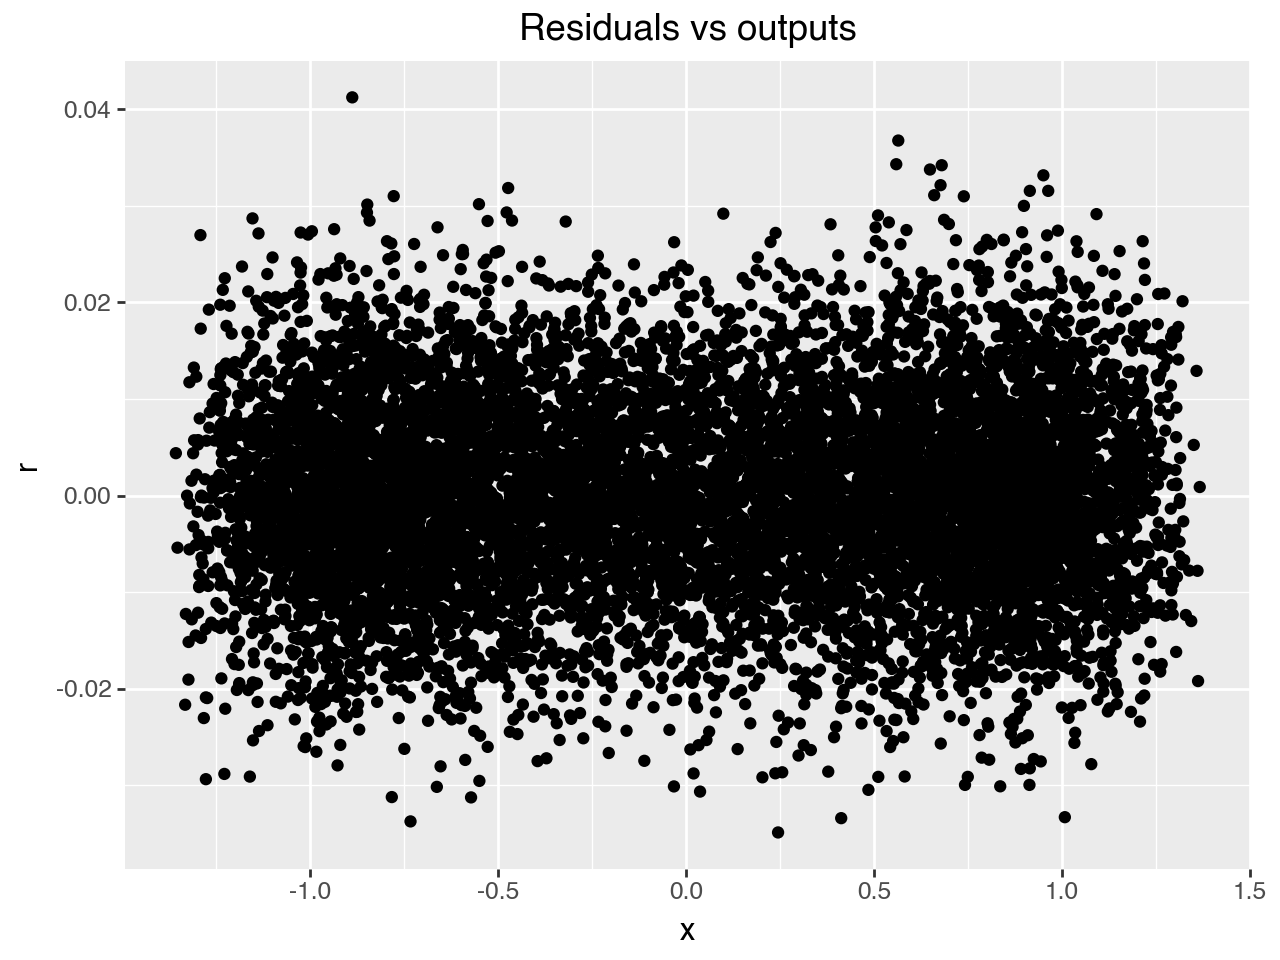

In [10]:
display(ggplot(DataFrame({'r': residuals, 'x': y})) + geom_point(aes(x='x', y='r')) + ggtitle('Residuals vs outputs'))

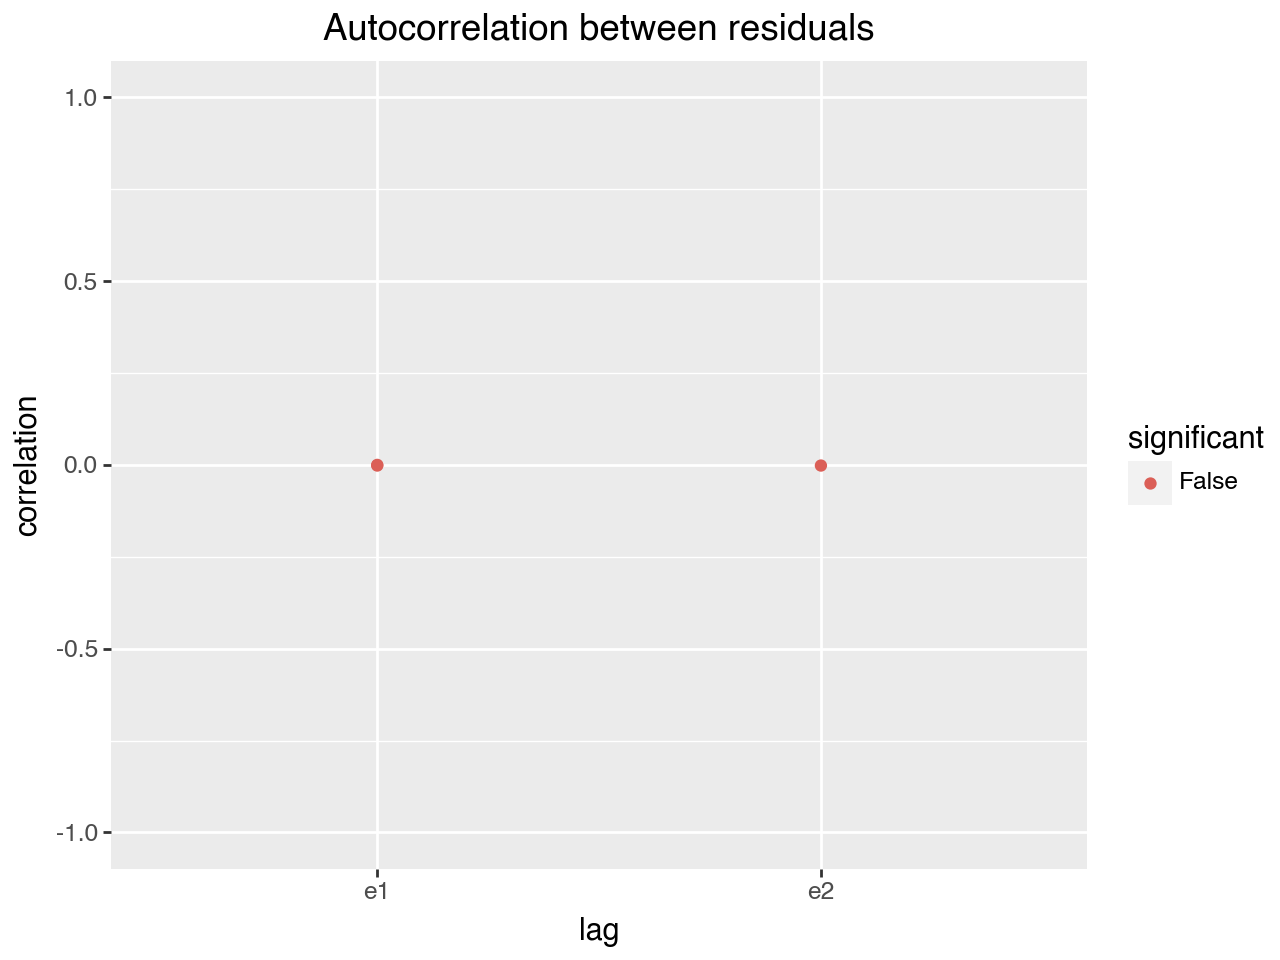

In [11]:
res_0 = residuals[: len(residuals)-3]
res_1 = residuals.shift(-1)[: len(residuals)-3]
res_2 = residuals.shift(-2)[: len(residuals)-3]
res_3 = residuals.shift(-2)[: len(residuals)-3]

pvalue = [None] * 3
cor_coef = [None] * 3
cor_coef[0], pvalue[0] = pearsonr(res_0, res_1)
cor_coef[1], pvalue[1] = pearsonr(res_0, res_2)
cor_coef[2], pvalue[2] = pearsonr(res_0, res_3)



sdf = DataFrame({'lag': ['e1', 'e1', 'e2'], 'correlation': cor_coef, 'pvalue': pvalue}).assign(significant=lambda df: df['pvalue'] < 0.05)
p = ggplot(sdf) + geom_point(aes(x='lag', y='correlation', colour='significant'))
p = p + ylim(-1,1) + ggtitle('Autocorrelation between residuals')
display(p)

## V. Prediction intervals

By assuming that the model fitted to the timeseries data is close to the real model
* We can use the variance of residuals to define 90\% prediction intervals for the first predictions
* Do simulations to find prediction intervals for long-term predictions. 
* It is possible to find close-term estimates for all multi-step predictions but we defer the discussion to [Markov chains with continous state space](./08_markov_chains_with_continous_state_space.ipynb) 

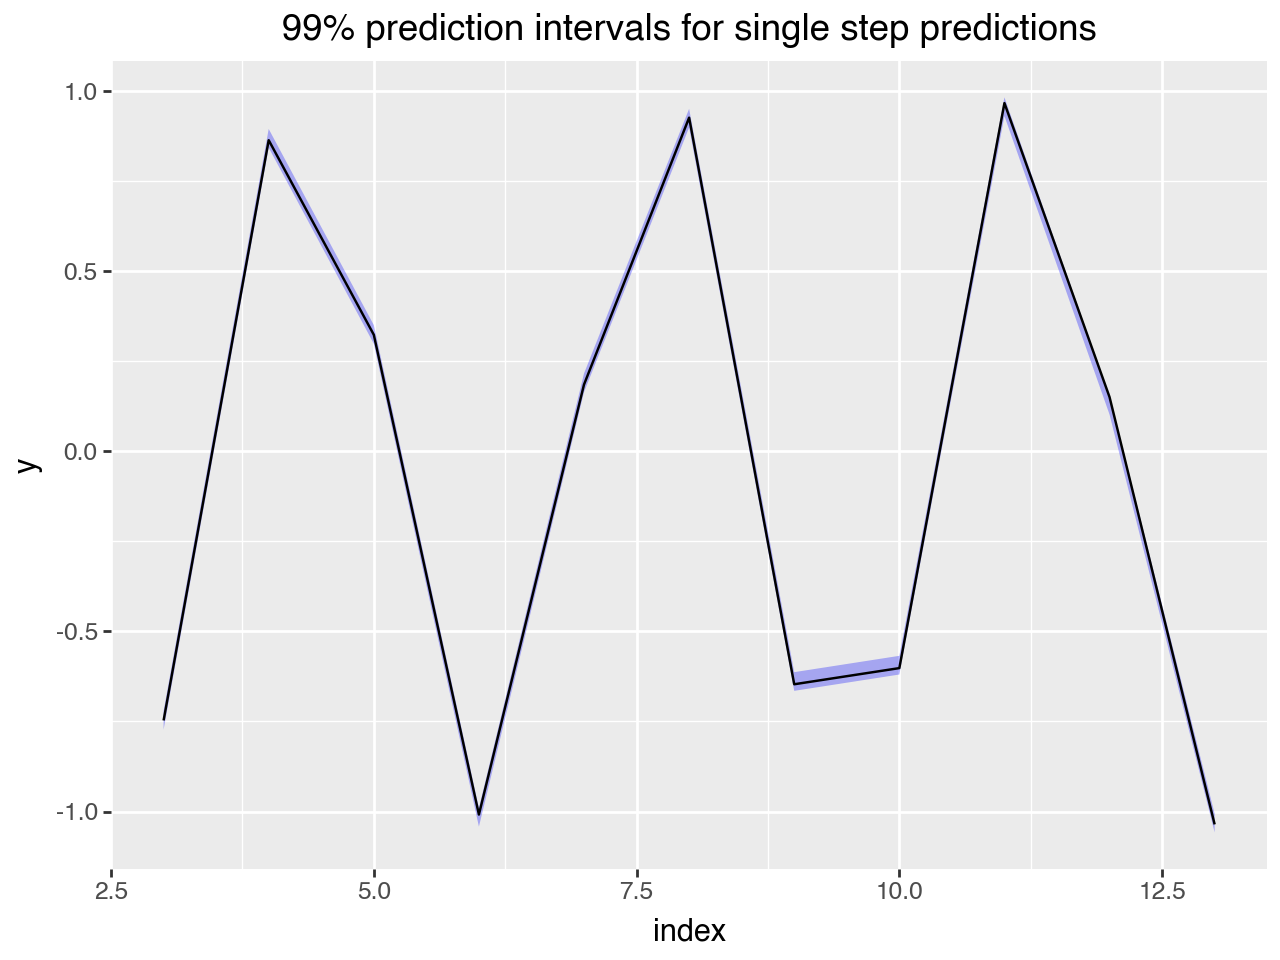

In [12]:
sigma = residuals.std()

sdf = (DataFrame({'yp': model.predict(X), 'y': y }) #df.loc[ 3:, 'x']
       .assign(y0=lambda df: df['yp'] + norm.ppf(0.005, loc=0, scale=sigma))
       .assign(y1=lambda df: df['yp'] + norm.ppf(0.995, loc=0, scale=sigma))
       .reset_index())

p = ggplot(sdf.loc[:10, :]) 
p = p + geom_ribbon(aes(x='index', ymin='y0', ymax='y1'), fill='blue', alpha=0.3)
p = p + geom_line(aes(x='index', y='y'))
p + ggtitle('99% prediction intervals for single step predictions')

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/cr/l8g02vwn2t14h_vldc4bdvyh0000gn/T/ipykernel_31326/2244247754.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


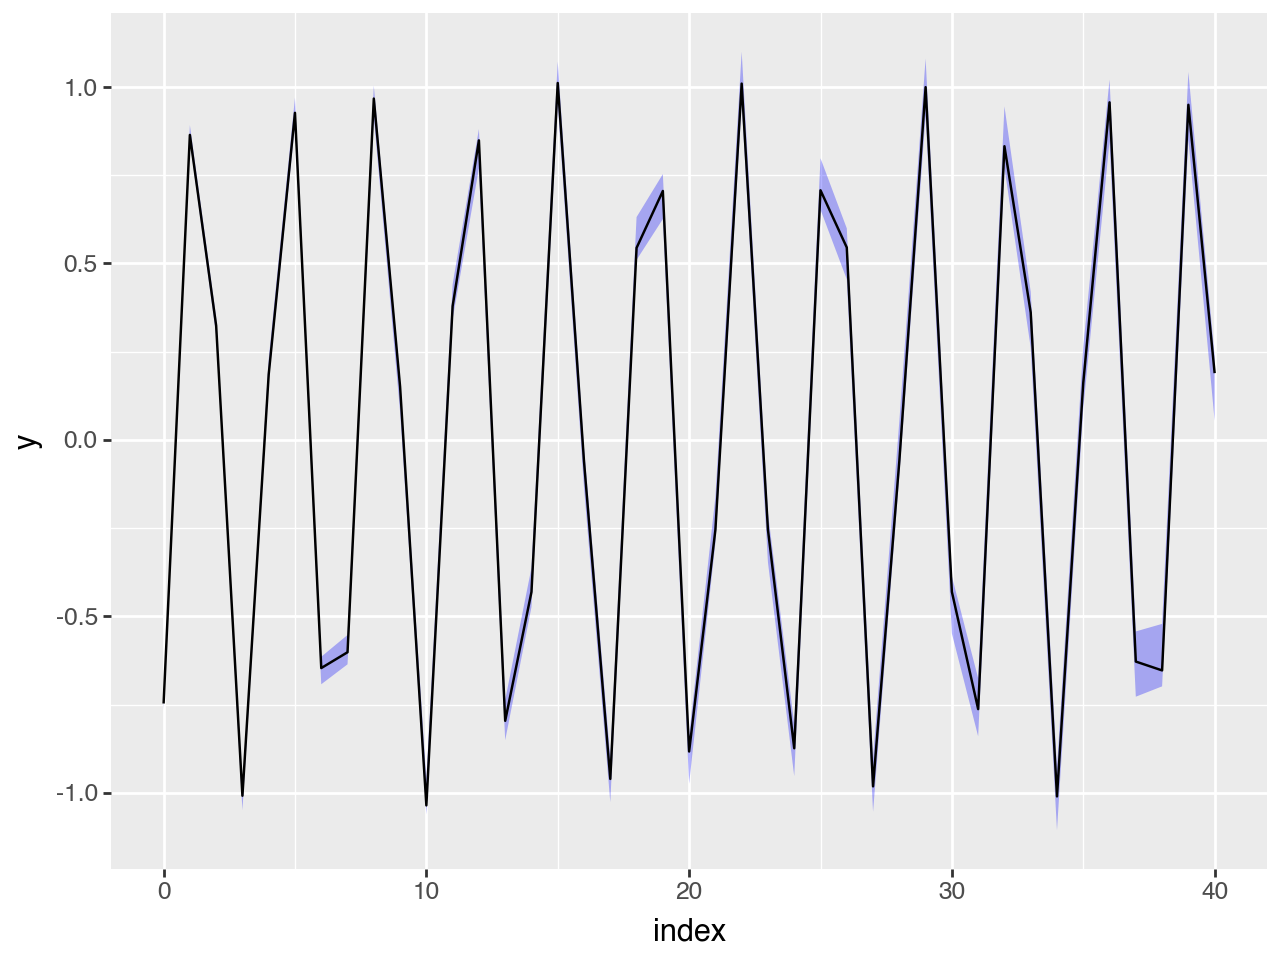

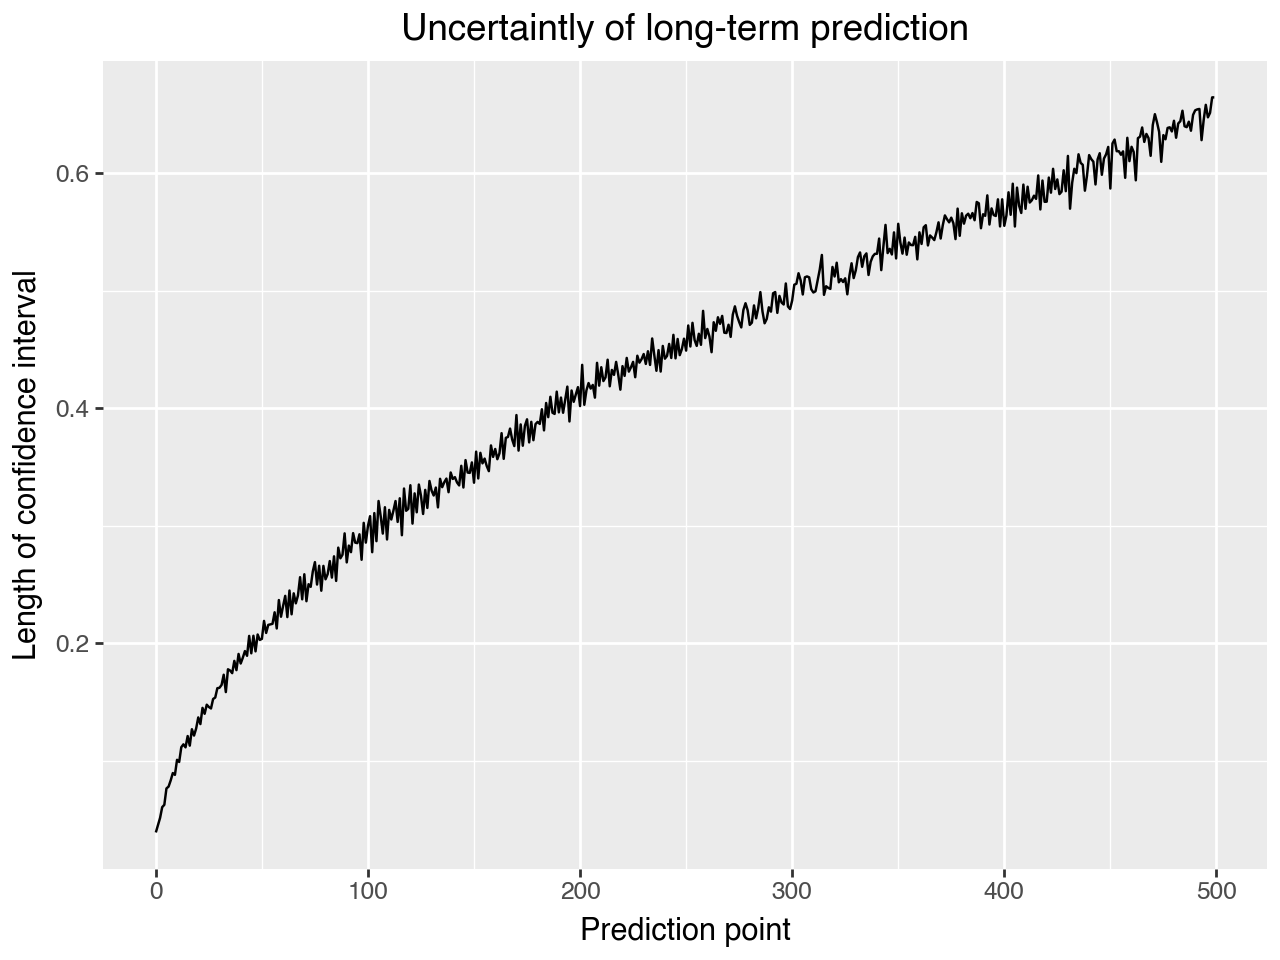

In [13]:
k = 500
r = 1000
LTP = np.full([k, r], fill_value=np.nan)

for j in tnrange(r):
    s = X.iloc[0]
    for i in range(k): 
        yp = sum(w[:3] * s) + w[3] + norm.rvs(size=1, loc=0, scale=sigma)[0]
        s = [yp, s[0], s[1]]
        LTP[i,j] = yp

sdf = (DataFrame(np.quantile(LTP, [0.025, 0.975], axis=1).T, columns=['y0', 'y1'])
       .assign(y=df.loc[3:3+k-1,'x'].values)
       .assign(diff=lambda df: df['y1']-df['y0'])
       .reset_index()) 

p = ggplot(sdf.loc[:40, :]) 
p = p + geom_ribbon(aes(x='index', ymin='y0', ymax='y1'), fill='blue', alpha=0.3)
p = p + geom_line(aes(x='index', y='y'))
p + ggtitle('95% prediction intervals for single step predictions')
display(p)

p = ggplot(sdf)
p = p + geom_line(aes(x='index', y='diff'))
p = p + ylab('Length of confidence interval') + xlab('Prediction point')
p = p + ggtitle('Uncertaintly of long-term prediction')
display(p)

# Homework

## 4.1  Comparison of different linear models  (<font color='red'>2p</font>)  

A priori one does not know the lag-structure, i.e. how many previous states are needed to reliably predict the next state. This is usually desicde by drawing a knee-plot where the $x$-axis depicts the number used observations and $y$-axis depicts the test error. Draw the corresponding plot by considerin up to 10 observations. Interpret the plot and choose the optimal lag structure. (<font color='red'>1p</font>). If several models are close interm of performance draw also diagnostic plots and compare their performance on long-term prediction. For that predict 10 values ahead and draw the 90\% prediction interval. Observe whether predictions fall into this range or not.

In [14]:
# Model fitting
model = LinearRegression()
model.fit(X[['s0']], y)
print('R^2 score: {}'.format(model.score(X[['s0']], y)))

R^2 score: 0.062458614443779314


In [15]:
model = LinearRegression()
model.fit(X[['s0', 's1']], y)
print('R^2 score: {}'.format(model.score(X[['s0', 's1']], y)))

R^2 score: 0.9998101602126269


In [16]:
model = LinearRegression()
model.fit(X, y)
print('R^2 score: {}'.format(model.score(X, y)))

R^2 score: 0.9998102071811406
